In [1]:
import json
import os
import pickle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Path configurations - Updated for audio and video data
AUDIO_BASE_PATH = "F:/Dataset/DFDC/Predicted_Speech_VA"
VIDEO_BASE_PATH = "F:/Dataset/DFDC/Predicted_Video_VA"
FAKE_LABELS_PATH = "D:/fakeaudio/audio_manipulation_detected.csv"
REAL_LABELS_PATH = "D:/fakeaudio/original_videos.csv"
PARTS = ["dfdc_train_part_45", "dfdc_train_part_46", "dfdc_train_part_47", 
         "dfdc_train_part_48", "dfdc_train_part_49"]

In [3]:
# Function to load and preprocess data for specific parts
def load_and_preprocess_by_part(parts, max_seq_length=100):
    """
    Load and preprocess both audio and video data from specific parts.
    
    Args:
        parts: List of parts to load (e.g., ["dfdc_train_part_45", "dfdc_train_part_46"])
        max_seq_length: Maximum sequence length for padding/truncating
    
    Returns:
        X: Features (combined valence-arousal sequences)
        y: Labels (0 for REAL, 1 for FAKE)
        filenames: List of filenames for reference
    """
    # Load label files
    fake_df = pd.read_csv(FAKE_LABELS_PATH)
    real_df = pd.read_csv(REAL_LABELS_PATH)
    
    # Combine and create a dictionary for quick lookup
    fake_df['filename'] = fake_df['filename'].str.replace('.mp4', '.csv')
    real_df['filename'] = real_df['filename'].str.replace('.mp4', '.csv')
    
    # Combine the dataframes
    all_labels_df = pd.concat([fake_df, real_df])
    
    # Create a dictionary for quick lookup
    labels_dict = dict(zip(all_labels_df['filename'], all_labels_df['label']))
    
    # Store all sequences and labels
    all_sequences = []
    all_labels = []
    all_filenames = []
    skipped_files = []
    
    # Load data from each specified part
    for part in parts:
        audio_part_path = os.path.join(AUDIO_BASE_PATH, part)
        video_part_path = os.path.join(VIDEO_BASE_PATH, part)
        print(f"Processing part: {part}")
        
        # Process data for both REAL and FAKE folders
        for category in ["REAL", "FAKE"]:
            label = 0 if category == "REAL" else 1
            
            audio_folder = os.path.join(audio_part_path, category)
            video_folder = os.path.join(video_part_path, category)
            
            if not os.path.exists(audio_folder) or not os.path.exists(video_folder):
                print(f"Skipping {category} folder in {part} - one or both directories don't exist")
                continue
            
            # Get list of files in audio folder
            audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.csv')]
            
            for audio_filename in audio_files:
                # Extract base filename without _MFCC
                base_filename = audio_filename.replace('_MFCC.csv', '.csv')
                video_filename = base_filename
                
                audio_file_path = os.path.join(audio_folder, audio_filename)
                video_file_path = os.path.join(video_folder, video_filename)
                
                # Skip if video file doesn't exist
                if not os.path.exists(video_file_path):
                    skipped_files.append((audio_filename, "Missing video file"))
                    continue
                
                try:
                    # Load both CSV files
                    audio_df = pd.read_csv(audio_file_path)
                    video_df = pd.read_csv(video_file_path)
                    
                    # Check if both dataframes have enough rows
                    if len(audio_df) == 0 or len(video_df) == 0:
                        skipped_files.append((audio_filename, "Empty dataframe"))
                        continue
                    
                    # Make sure we have the same number of frames
                    min_frames = min(len(audio_df), len(video_df))
                    audio_df = audio_df.iloc[:min_frames]
                    video_df = video_df.iloc[:min_frames]
                    
                    # Extract valence and arousal values from both sources
                    audio_va = audio_df[['predicted_valence', 'predicted_arousal']].values
                    video_va = video_df[['predicted_valence', 'predicted_arousal']].values
                    
                    # Combine the features (4 features now: audio_valence, audio_arousal, video_valence, video_arousal)
                    combined_features = np.hstack((audio_va, video_va))
                    
                    # Add to our lists
                    all_sequences.append(combined_features)
                    all_labels.append(label)
                    all_filenames.append(base_filename)
                    
                except Exception as e:
                    print(f"Error processing {audio_filename}: {e}")
                    skipped_files.append((audio_filename, str(e)))
    
    print(f"Total skipped files: {len(skipped_files)}")
    print(f"Successfully processed: {len(all_sequences)} files")
    
    # Pad/truncate sequences to max_seq_length
    X = []
    for seq in all_sequences:
        if len(seq) > max_seq_length:
            # Truncate
            X.append(seq[:max_seq_length])
        else:
            # Pad with zeros
            padded_seq = np.zeros((max_seq_length, 4))  # Now 4 features
            padded_seq[:len(seq)] = seq
            X.append(padded_seq)
    
    X = np.array(X)
    y = np.array(all_labels)
    
    return X, y, all_filenames

In [4]:
# Function to build the BiLSTM model for combined audio-video
def build_bilstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    """
    Build a BiLSTM model for combined audio-video deepfake detection.
    
    Args:
        input_shape: Shape of input data (seq_length, features)
        lstm_units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
    
    Returns:
        model: Compiled Keras model
    """
    model = Sequential()
    
    # First BiLSTM layer with return sequences
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), 
                            input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second BiLSTM layer
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Dense layers for classification
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    # Print model summary
    model.summary()
    
    return model

In [5]:
# Function to train the model with separate validation data
def train_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Train the BiLSTM model with separate validation data.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        epochs: Number of training epochs
        batch_size: Batch size for training
    
    Returns:
        model: Trained model
        history: Training history
        scaler: Fitted scaler for normalization
    """
    # Normalize the data
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
    
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    
    # Reshape back to original shape
    X_train = X_train_scaled.reshape(X_train.shape)
    X_val = X_val_scaled.reshape(X_val.shape)
    
    # Build the model
    model = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Define callbacks
    checkpoint = ModelCheckpoint('best_combined_audio_video_model.keras', monitor='val_accuracy', 
                                save_best_only=True, mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint, early_stopping, reduce_lr],
                        verbose=1)
    
    return model, history, scaler

In [6]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate the trained model.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test labels
        scaler: Fitted scaler for normalization
    
    Returns:
        None, but prints evaluation metrics
    """
    # Normalize the test data
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler.transform(X_test_reshaped)
    X_test = X_test_scaled.reshape(X_test.shape)
    
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('combined_model_confusion_matrix.png')
    plt.show()
    
    # Plot ROC curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('combined_model_roc_curve.png')
    plt.show()


In [7]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot the training history.
    
    Args:
        history: Training history from model.fit()
    
    Returns:
        None, but creates plots
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('combined_model_training_history.png')
    plt.show()


In [8]:
# Main function to run the pipeline
def main():
    # Set the maximum sequence length
    max_seq_length = 100
    
    print("Loading and preprocessing training data (parts 45, 46)...")
    X_train, y_train, train_filenames = load_and_preprocess_by_part(
        ["dfdc_train_part_45", "dfdc_train_part_46"], max_seq_length)
    
    print("Loading and preprocessing validation data (part 47)...")
    X_val, y_val, val_filenames = load_and_preprocess_by_part(
        ["dfdc_train_part_47"], max_seq_length)
    
    print("Loading and preprocessing test data (parts 48, 49)...")
    X_test, y_test, test_filenames = load_and_preprocess_by_part(
        ["dfdc_train_part_48", "dfdc_train_part_49"], max_seq_length)
    
    # Check if we have data to process
    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print("ERROR: One or more datasets are empty. Please check the data paths and file matching.")
        return
    
    print(f"Training data: {X_train.shape[0]} samples")
    print(f"Training class distribution: {np.bincount(y_train)}")
    
    print(f"Validation data: {X_val.shape[0]} samples")
    print(f"Validation class distribution: {np.bincount(y_val)}")
    
    print(f"Test data: {X_test.shape[0]} samples")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    print(f"Input shape: {X_train.shape[1:]}")  # Should show (100, 4) for the combined features
    
    print("Training model...")
    model, history, scaler = train_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    
    print("Evaluating model on test set...")
    evaluate_model(model, X_test, y_test, scaler)
    
    print("Plotting training history...")
    plot_training_history(history)
    
    # Save the model, scaler, and metadata
    model.save('deepfake_detection_combined_audio_video_bilstm.keras')
    
    # Save the scaler
    with open('combined_audio_video_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    # Save model metadata
    metadata = {
        'max_seq_length': max_seq_length,
        'train_samples': X_train.shape[0],
        'val_samples': X_val.shape[0],
        'test_samples': X_test.shape[0],
        'features': X_train.shape[2],
        'lstm_units': 64,  # Update this if you change the model architecture
        'training_date': time.strftime('%Y-%m-%d %H:%M:%S'),
        'data_type': 'combined_audio_video',
        'audio_data_path': AUDIO_BASE_PATH,
        'video_data_path': VIDEO_BASE_PATH
    }
    
    with open('combined_audio_video_model_metadata.json', 'w') as f:
        json.dump(metadata, f)
    
    print("Model saved as 'deepfake_detection_combined_audio_video_bilstm.keras'")
    print("Scaler saved as 'combined_audio_video_scaler.pkl'")
    print("Metadata saved as 'combined_audio_video_model_metadata.json'")


Loading and preprocessing training data (parts 45, 46)...
Processing part: dfdc_train_part_45
Processing part: dfdc_train_part_46
Total skipped files: 0
Successfully processed: 2684 files
Loading and preprocessing validation data (part 47)...
Processing part: dfdc_train_part_47
Total skipped files: 0
Successfully processed: 1420 files
Loading and preprocessing test data (parts 48, 49)...
Processing part: dfdc_train_part_48
Processing part: dfdc_train_part_49
Total skipped files: 0
Successfully processed: 3321 files
Training data: 2684 samples
Training class distribution: [ 715 1969]
Validation data: 1420 samples
Validation class distribution: [ 353 1067]
Test data: 3321 samples
Test class distribution: [ 797 2524]
Input shape: (100, 4)
Training model...


C:\Users\Ashwanth GP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,921 (570.00 KB)

 Trainable params: 145,217 (567.25 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7420 - auc: 0.7890 - loss: 0.6069 - precision: 0.8881 - recall: 0.7445
Epoch 1: val_accuracy improved from -inf to 0.84085, saving model to best_combined_audio_video_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.7428 - auc: 0.7900 - loss: 0.6055 - precision: 0.8884 - recall: 0.7454 - val_accuracy: 0.8408 - val_auc: 0.9118 - val_loss: 0.4503 - val_precision: 0.8405 - val_recall: 0.9728 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9032 - auc: 0.9439 - loss: 0.3373 - precision: 0.9608 - recall: 0.9065
Epoch 2: val_accuracy improved from 0.84085 to 0.90000, saving model to best_combined_audio_video_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9033 - auc: 0.9439 - loss: 0.3369 - precision: 0.9608 - recall: 0.9067 - val_accuracy: 0.9000 - val_auc: 0.9343 - val_loss: 0.3595 - val_precision: 0.9163 - val_recall: 0.9541 - learning_rate: 0.0010
Ep

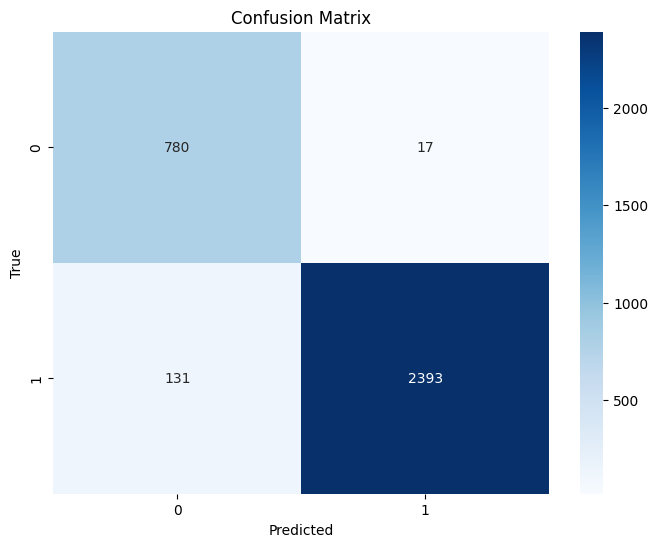

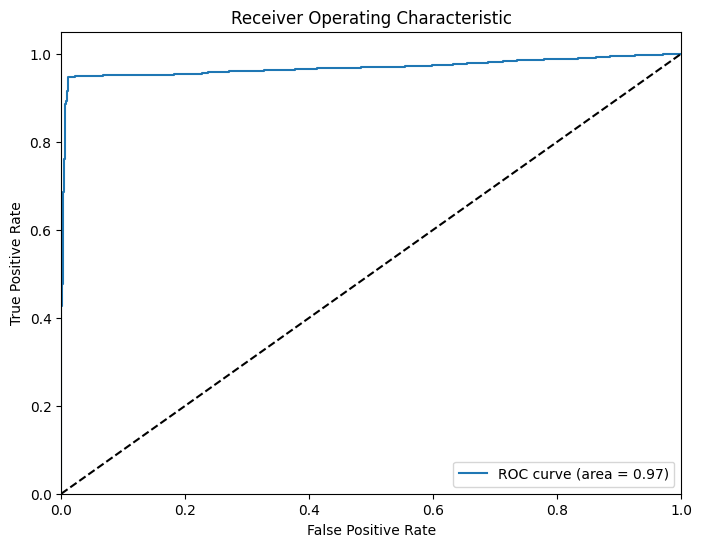

Plotting training history...


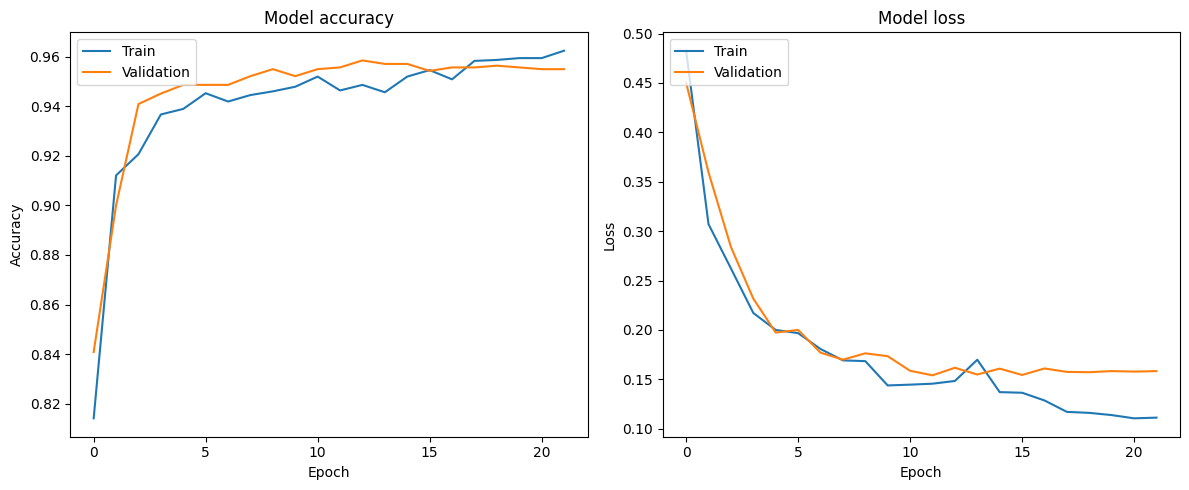

Model saved as 'deepfake_detection_combined_audio_video_bilstm.keras'
Scaler saved as 'combined_audio_video_scaler.pkl'
Metadata saved as 'combined_audio_video_model_metadata.json'


In [10]:
if __name__ == "__main__":
    main()